**Introduction to surrogate Modelling**

Pierre Kerfriden, Mines ParisTech / Cardiff University

Content:

- Exercise 1. Frequentist model selection
- Demo 2. Bayesian generalised linear regression
- Exercise 3. Nonparametric bayesian modelling
- Exercise 4. Bayesian optimisation

---


**Exercise 1. Frequentist model selection**

1. Propose an algorithm to select the polynomial order optimally. The number of model evaluations is fixed for now (*e.g.* 10 points) 
2. Propose an algorithm to select number of model evaluations optimally when the polynomial order is fixed
3. Propose an algorithm to select the polynomial order AND number of model evaluations optimally
4. Propose an algorithm to select the polynomial order, number of model evaluations and ridge regularisation parameter optimally

Note: np.random.seed(x) allows you to fix the seed of the random generator. If unchanged, the code will generate the same pseudo-random number every time it is ran. Change x if you want to generate new random evaluation points.



---


**Exercise 2. Bayesian model selection** 

- Select the polynomial order for N=30 model evaluation (random sequence)
- Suggest an algorithm for choosing the polynomial order (which may differ for the two input dimensions) and the number of model evaluations

Note: you may also switch to a compressive sensing model (TypeRegularisation = 1) and investigate the effect of the corresponding regularisation coefficient (RegulCoeff)



---


**Exercise 3: Nonparametric bayesian modelling: Gaussian Process Regression**

1. Implement an exponential Kernel: modify the Covariance matrix and the cross-covariance vector
2. Implement the automatic choice of the covariance length scale by maximising the data likelihood (at the moment, the amplitude of the Kernel is optimised
3. Optimise both the amplitude and length-scale parameters

Note: look for comments "... is to be updated" in the code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt    
from scipy.optimize import fmin_bfgs, fmin, fminbound

class SimpleModel1D:
    
    def eval(self,x) :
        f = np.sin(3.0*x-2.25) + abs(x) + x
        return f
    
    def plot(self,xLim,NPoint):
        xPlot = np.linspace(xLim[0],xLim[1], NPoint)
        yPlot = self.eval(xPlot)
        plt.plot(xPlot,yPlot,c='black',)

In [ ]:
class GPRegressionMM1D:
    
    def __init__(self): 
        self.FullModel = None       # Full model
        self.Centers = None         # list of coordinates of data points ("x")
        self.Vals = None            # list of function values at data points ("y")
        self.NbRBFs = 10            # Number of data points
        self.TypeQuadrature = 'MC'  # Type of automatised sempling 'MC' (random) or 'Uniform' (deterministic)
        self.l = 1.0                # length scale of exponential covariance Kernel
        self.Covariance = None      # data covariance matrix
        self.A = 1.0                # amplitude of exponential covariance Kernel
        self.sigma = 1.e-8          # amplitude of white noise Kernel
    
    def BuildQuadrature(self):
        if self.TypeQuadrature == 'MC':
            self.Centers = 2.0 * np.random.rand(self.NbRBFs,1) - 1.0
        elif self.TypeQuadrature == 'Uniform':
            self.Centers = np.linspace(-1,1,self.NbRBFs)
        else:
            print('nod coded')
    
    def Fit(self):
        self.Vals = np.zeros((self.NbRBFs,1))
        for i in range(self.NbRBFs):
            self.Vals[i] = self.FullModel.eval(self.Centers[i])
        self.Covariance = np.zeros((len(self.Centers),len(self.Centers)))

        #self.Covariance = self.sigma * np.identity(len(self.Centers))           # Covariance matrix is to be updated
        for i in range(len(self.Centers)):
            for j in range(len(self.Centers)):
                distance = self.Centers[i] - self.Centers[j]
                self.Covariance[i,j] = self.A * np.exp( -1.0/(2*self.l**2) * distance**2 )
        
        self.Covariance = self.Covariance + self.sigma * np.identity(len(self.Centers))

        #print('np.linalg.cond(self.Covariance) ', np.linalg.cond(self.Covariance))
    
    def eval(self,x) :
        CrossCo = np.zeros((len(self.Centers),1))
        for i in range(len(self.Centers)):
            #CrossCo[i] = 0.                                                     # Covariance vector is to be updated
            distance = self.Centers[i] - x
            CrossCo[i] = self.A * np.exp( -1.0/(2*self.l**2) * distance**2 )
        Tmp = np.linalg.solve(self.Covariance,self.Vals)
        f = np.dot(np.transpose(CrossCo),Tmp)
        
        Tmp = np.linalg.solve(self.Covariance,CrossCo)
        Covf = self.A - np.dot(np.transpose(CrossCo),Tmp)
        return f, Covf

    def LogLikelihood(self) :
        Tmp = np.linalg.solve(self.Covariance,self.Vals)
        # https://blogs.sas.com/content/iml/2012/10/31/compute-the-log-determinant-of-a-matrix.html
        LogLike = - 0.5 * np.dot(np.transpose(self.Vals),Tmp) - 0.5 * self.Covariance.shape[0] * np.log(2*np.pi) #(eq. 2.30 rasmussen book Gaussian Process for Machine Learning)
        #logdet = np.log(np.linalg.det(self.Covariance))
        sign, logdet = np.linalg.slogdet(self.Covariance)
        LogLike = LogLike - 0.5*logdet
        return LogLike

    def Objectif(self,mu):
        self.l = np.exp(mu[0]) 
        self.A = np.exp(mu[1]) 
        self.sigma = np.exp(mu[2])
        self.Fit() # recompute data covariance
        return -1.0*self.LogLikelihood()

    def Optimise(self):
        muInit = [0.1 ,  0., -10]
        InitVal = self.Objectif(muInit)
        #mu_opt = fmin_bfgs( self.Objectif, muInit , gtol=1e-3)
        mu_opt = fmin( self.Objectif , muInit )  
        print('optimal parameter:', mu_opt, ' f value at optimal :', self.Objectif(mu_opt), 'Init : ',  muInit ,  ' f value at init :', InitVal )


    def plot(self,xLim,NPoint):
        xPlot = np.linspace(xLim[0],xLim[1], NPoint)
        # plot posterior mean and 95% credible region
        yPlot = np.copy(xPlot)
        yPlotP = np.copy(xPlot)
        yPlotM= np.copy(xPlot)
        for i in range(len(xPlot)):
            f, Covf = self.eval(xPlot[i])
            yPlot[i] = f
            yPlotP[i] = f + 1.96 * Covf
            yPlotM[i] = f - 1.96 * Covf
        plt.plot(xPlot,yPlot,'blue')
        plt.plot(xPlot,yPlotP,'r')
        plt.plot(xPlot,yPlotM,'g')
        plt.scatter(self.Centers,self.Vals, marker='o', c='black')

 ----------------------------------
 ---------- Exercise GP -----------
 ----------------------------------
 1. Implement an exponential Kernel: modify the Covariance matrix and the cross-covariance vector
 2. Propose a Greedy algorithm to iteratively add points to the data set
 3. Implement the automatic choice of the covariance length scale by maximising the data likelihood
 ---------------------------------------
 ---------- Gaussian process -----------
 ---------------------------------------


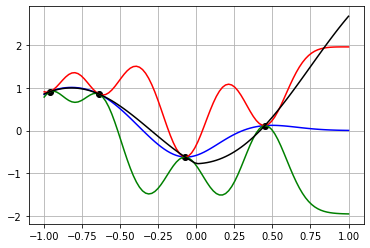

 ------------------------------------------------------
 ---------- Optimisation of data likelihood -----------
 ------------------------------------------------------
log likelihood [[-4.46064048]]
Optimization terminated successfully.
         Current function value: 3.625032
         Iterations: 253
         Function evaluations: 478
optimal parameter: [ -1.1734468   -0.89402719 -36.68218351]  f value at optimal : [[3.62503213]] Init :  [0.1, 0.0, -10]  f value at init : [[108.68507082]]


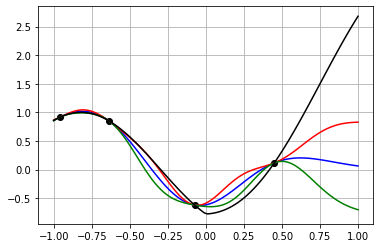

In [ ]:
def GaussianProcessMetaModel1D():

    print(' ----------------------------------')
    print(' ---------- Exercise GP -----------')
    print(' ----------------------------------')
    print(' 1. Implement an exponential Kernel: modify the Covariance matrix and the cross-covariance vector')
    print(' 2. Propose a Greedy algorithm to iteratively add points to the data set')
    print(' 3. Implement the automatic choice of the covariance length scale by maximising the data likelihood')

    NSampling = 4
    SmoothingLength = 0.2

    #TypeTypeQuadrature = 'Uniform'
    TypeTypeQuadrature = 'MC'

    RidgeCoeff = 1e-10
    np.random.seed(11)

    print(' ---------------------------------------')
    print(' ---------- Gaussian process -----------')
    print(' ---------------------------------------')

    plt.figure()
    M = SimpleModel1D()
    #MM = KernelRegressionMM1D() 
    MM = GPRegressionMM1D() 
    MM.FullModel = M
    MM.TypeQuadrature = TypeTypeQuadrature
    MM.NbRBFs = NSampling # Number of uniformly, randomly distributed radial basis functions
    MM.l = SmoothingLength # length scale of Kernel smoother
    MM.RidgeCoeff = RidgeCoeff
    MM.BuildQuadrature()
    MM.Fit()
    MM.plot([-1,1],100)
    M.plot([-1,1],100)
    plt.grid()
    plt.show()

    print(' ------------------------------------------------------')
    print(' ---------- Optimisation of data likelihood -----------')
    print(' ------------------------------------------------------')

    print('log likelihood',MM.LogLikelihood())
    MM.Optimise()
    MM.plot([-1,1],100)
    M.plot([-1,1],100)
    plt.grid()
    plt.show()

GaussianProcessMetaModel1D() 

---


**Exercise 4: Bayesian optimisation**

Suggest and implement a Greedy algorithm to iteratively add points to the data set based on (a) minimising uncertainty (b) finding the location of the minimum of the function

Note: look for comment "change this" in the code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt    

class SimpleModel1D:
    
    def eval(self,x) :
        f = np.sin(3.0*x-2.25) + abs(x) + x
        return f
    
    def plot(self,xLim,NPoint):
        xPlot = np.linspace(xLim[0],xLim[1], NPoint)
        yPlot = self.eval(xPlot)
        plt.plot(xPlot,yPlot,c='black',)

In [ ]:
class GPRegressionMM1D:
    
    def __init__(self):
         
        self.FullModel = None       # Full model
        self.Centers = None         # list of coordinates of data points ("x")
        self.Vals = None            # list of function values at data points ("y")
        self.NbRBFs = 10            # Number of data points
        self.TypeQuadrature = 'MC'  # Type of automatised sempling 'MC' (random) or 'Uniform' (deterministic)
        self.l = 1.0                # length scale of exponential covariance Kernel
        self.Covariance = None      # data covariance matrix
        self.A = 1.0                # amplitude of exponential covariance Kernel
        self.sigma = 1.e-8          # amplitude of white noise Kernel
        self.ParameterSpace = [-1,1]
    
    def BuildQuadrature(self):
        if self.TypeQuadrature == 'MC':
            self.Centers = (self.ParameterSpace[1] - self.ParameterSpace[0]) * np.random.rand(self.NbRBFs,1) + self.ParameterSpace[0]
        elif self.TypeQuadrature == 'Uniform':
            self.Centers = np.linspace(-1,1,self.NbRBFs)
        else:
            print('nod coded')
    
    def Fit(self):
        self.Vals = np.zeros((len(self.Centers),1))
        for i in range(len(self.Centers)):
            self.Vals[i] = self.FullModel.eval(self.Centers[i])
        self.Covariance = np.zeros((len(self.Centers),len(self.Centers)))
        for i in range(len(self.Centers)):
            for j in range(len(self.Centers)):
                distance = self.Centers[i] - self.Centers[j]
                self.Covariance[i,j] = self.A * np.exp( -1.0/(2*self.l**2) * distance**2 )

        self.Covariance = self.Covariance + self.sigma * np.identity(len(self.Centers))      
        print('np.linalg.cond(self.Covariance) ', np.linalg.cond(self.Covariance))
    
    def eval(self,x) :
        CrossCo = np.zeros((len(self.Centers),1))
        for i in range(len(self.Centers)):
            distance = self.Centers[i] - x
            CrossCo[i] = self.A * np.exp( -1.0/(2*self.l**2) * distance**2 )
        Tmp = np.linalg.solve(self.Covariance,self.Vals)
        f = np.dot(np.transpose(CrossCo),Tmp)
        
        Tmp = np.linalg.solve(self.Covariance,CrossCo)
        Covf = self.A - np.dot(np.transpose(CrossCo),Tmp)
        return f, Covf

    def OptimNewPoint(self) :
        #NewPoint = 2.0 * np.random.rand(1,1) - 1.0 # change this !!!
        #grid_search = np.linspace(-1, 1, 100)
        grid_search = 2.0*np.random.rand(50,1) - 1.0
        min_val = 1.0e10
        for i in range(len(grid_search)):
          f, Covf = self.eval(grid_search[i])
          if min_val > f - 1.96*Covf:
            min_val = f - 1.96*Covf
            NewPoint = grid_search[i]

        print('NewPoint',NewPoint)
        self.Centers = np.append(self.Centers,NewPoint)

    def ActiveLearning(self,NActiveLearning) :
        for i in range(NActiveLearning):
            self.OptimNewPoint()
            self.Fit()
            self.plot(self.ParameterSpace,100)
            plt.grid()
            plt.show()
    
    def plot(self,xLim,NPoint):
        xPlot = np.linspace(xLim[0],xLim[1], NPoint)
        # plot posterior mean and 95% credible region
        yPlot = np.copy(xPlot)
        yPlotP = np.copy(xPlot)
        yPlotM= np.copy(xPlot)
        for i in range(len(xPlot)):
            f, Covf = self.eval(xPlot[i])
            yPlot[i] = f
            yPlotP[i] = f + 1.96 * Covf
            yPlotM[i] = f - 1.96 * Covf
        plt.plot(xPlot,yPlot,'blue')
        plt.plot(xPlot,yPlotP,'r')
        plt.plot(xPlot,yPlotM,'g')
        plt.scatter(self.Centers,self.Vals, marker='o', c='black')

 ----------------------------------
 ---------- Exercise GP -----------
 ----------------------------------
 1. Implement an exponential Kernel Covariance matrix 
 2. Propose a Greedy algorithm to iteratively add points to the data set
 3. Implement the automatic choice of the covariance length scale by maximising the data likelihood
 ---------------------------------------
 ---------- Gaussian process -----------
 ---------------------------------------
np.linalg.cond(self.Covariance)  1.7591197448315234


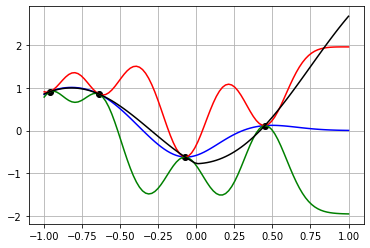

 --------------------------------------
 ---------- Active Learning -----------
 --------------------------------------
NewPoint [0.97334666]
np.linalg.cond(self.Covariance)  1.759120215272476


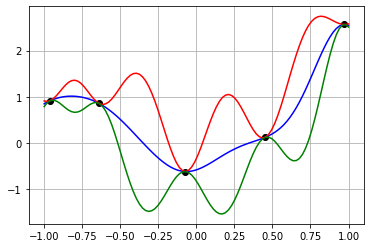

NewPoint [0.15111708]
np.linalg.cond(self.Covariance)  4.217983453610656


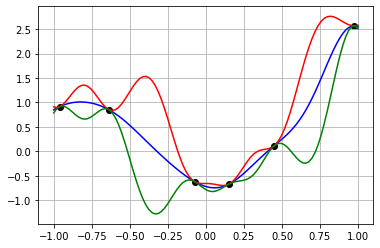

NewPoint [-0.31257339]
np.linalg.cond(self.Covariance)  7.042240436112594


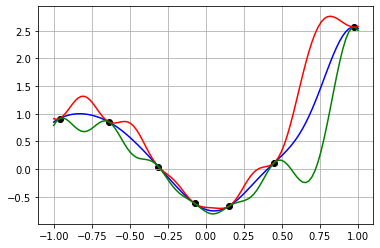

NewPoint [0.10785455]
np.linalg.cond(self.Covariance)  470.6134924296426


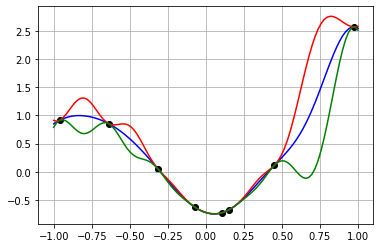

In [ ]:
def GaussianProcessMetaModel1D():

    print(' ----------------------------------')
    print(' ---------- Exercise GP -----------')
    print(' ----------------------------------')
    print(' 1. Implement an exponential Kernel Covariance matrix ')
    print(' 2. Propose a Greedy algorithm to iteratively add points to the data set')
    print(' 3. Implement the automatic choice of the covariance length scale by maximising the data likelihood')

    NSampling = 4
    SmoothingLength = 0.2

    #TypeTypeQuadrature = 'Uniform'
    TypeTypeQuadrature = 'MC'

    RidgeCoeff = 1e-10
    np.random.seed(11)

    print(' ---------------------------------------')
    print(' ---------- Gaussian process -----------')
    print(' ---------------------------------------')

    plt.figure()
    M = SimpleModel1D()
    #MM = KernelRegressionMM1D() 
    MM = GPRegressionMM1D() 
    MM.FullModel = M
    MM.TypeQuadrature = TypeTypeQuadrature
    MM.ParameterSpace = [-1,1]
    MM.NbRBFs = NSampling # Number of uniformly, randomly distributed radial basis functions
    MM.l = SmoothingLength # length scale of Kernel smoother
    MM.RidgeCoeff = RidgeCoeff
    MM.BuildQuadrature()
    MM.Fit()
    MM.plot(MM.ParameterSpace,100)
    M.plot([-1,1],100)
    plt.grid()
    plt.show()

    print(' --------------------------------------')
    print(' ---------- Active Learning -----------')
    print(' --------------------------------------')

    NActiveLearning = 4
    MM.ActiveLearning(NActiveLearning)

GaussianProcessMetaModel1D() 